In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 5.90881872177124
(14019, 1, 11025)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 5s 2s/step - loss: 1430.7257
(1, 11025)


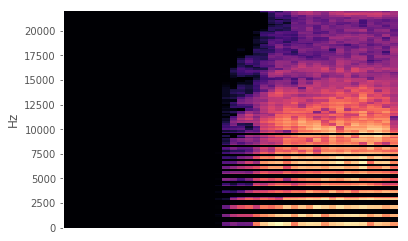

(14019, 128, 44)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])
cat_targets = np.repeat(c_targets, mfccs.shape[1])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
frames = mfccs

In [19]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(14019, 128, 44, 1)

In [20]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 36, 32)       2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

9532/9532 [==============================] - 4s 431us/step - loss: 0.4193 - acc: 0.7932 - mean_absolute_error: 0.2902 - val_loss: 0.4715 - val_acc: 0.7635 - val_mean_absolute_error: 0.3217
Epoch 36/100
9532/9532 [==============================] - 4s 436us/step - loss: 0.4148 - acc: 0.7991 - mean_absolute_error: 0.2873 - val_loss: 0.4944 - val_acc: 0.7457 - val_mean_absolute_error: 0.3210
Epoch 37/100
9532/9532 [==============================] - 4s 435us/step - loss: 0.4156 - acc: 0.7996 - mean_absolute_error: 0.2869 - val_loss: 0.4758 - val_acc: 0.7594 - val_mean_absolute_error: 0.3180
Epoch 38/100
9532/9532 [==============================] - 4s 456us/step - loss: 0.4063 - acc: 0.8027 - mean_absolute_error: 0.2797 - val_loss: 0.4713 - val_acc: 0.7534 - val_mean_absolute_error: 0.3078
Epoch 39/100
9532/9532 [==============================] - 4s 431us/step - loss: 0.4038 - acc: 0.8067 - mean_absolute_error: 0.2789 - val_loss: 0.4639 - val_acc: 0.7641 - val_mean_absolute_error: 0.3150
Epo

Epoch 76/100
9532/9532 [==============================] - 4s 440us/step - loss: 0.3216 - acc: 0.8495 - mean_absolute_error: 0.2215 - val_loss: 0.5073 - val_acc: 0.7819 - val_mean_absolute_error: 0.2658
Epoch 77/100
9532/9532 [==============================] - 4s 463us/step - loss: 0.3130 - acc: 0.8511 - mean_absolute_error: 0.2164 - val_loss: 0.4617 - val_acc: 0.7950 - val_mean_absolute_error: 0.2735
Epoch 78/100
9532/9532 [==============================] - 4s 435us/step - loss: 0.3175 - acc: 0.8488 - mean_absolute_error: 0.2186 - val_loss: 0.4671 - val_acc: 0.8015 - val_mean_absolute_error: 0.2651
Epoch 79/100
9532/9532 [==============================] - 4s 436us/step - loss: 0.3117 - acc: 0.8524 - mean_absolute_error: 0.2139 - val_loss: 0.4551 - val_acc: 0.7980 - val_mean_absolute_error: 0.2607
Epoch 80/100
9532/9532 [==============================] - 4s 449us/step - loss: 0.3284 - acc: 0.8488 - mean_absolute_error: 0.2196 - val_loss: 0.4935 - val_acc: 0.7760 - val_mean_absolute_erro

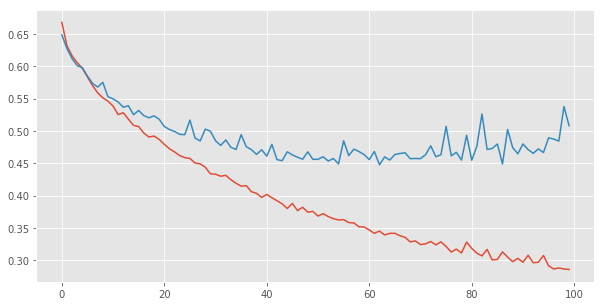

In [21]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

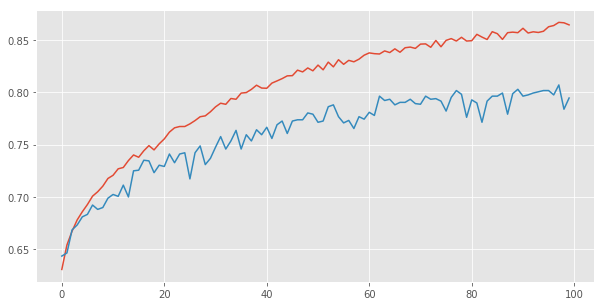

In [22]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.8084878744650499
Confusion matrix, without normalization
[[ 677  366]
 [ 171 1590]]


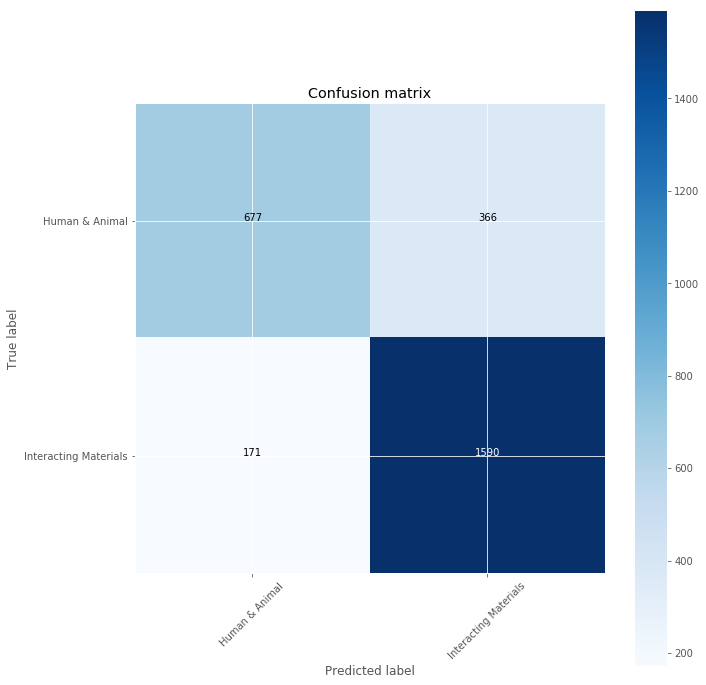

In [23]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [24]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [25]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, (3, 3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [26]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=epochs * 2, 
                       batch_size=batch, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

3515/3515 [==============================] - 2s 463us/step - loss: 1.8193 - acc: 0.4202 - mean_absolute_error: 0.0746 - val_loss: 1.7050 - val_acc: 0.4718 - val_mean_absolute_error: 0.0730
Epoch 31/200
3515/3515 [==============================] - 2s 463us/step - loss: 1.7578 - acc: 0.4401 - mean_absolute_error: 0.0736 - val_loss: 1.6802 - val_acc: 0.4750 - val_mean_absolute_error: 0.0706
Epoch 32/200
3515/3515 [==============================] - 2s 461us/step - loss: 1.7226 - acc: 0.4469 - mean_absolute_error: 0.0727 - val_loss: 1.6467 - val_acc: 0.4767 - val_mean_absolute_error: 0.0713
Epoch 33/200
3515/3515 [==============================] - 2s 473us/step - loss: 1.7348 - acc: 0.4444 - mean_absolute_error: 0.0727 - val_loss: 1.6772 - val_acc: 0.4863 - val_mean_absolute_error: 0.0714
Epoch 34/200
3515/3515 [==============================] - 2s 458us/step - loss: 1.7549 - acc: 0.4441 - mean_absolute_error: 0.0728 - val_loss: 1.6424 - val_acc: 0.4863 - val_mean_absolute_error: 0.0697
Epo

Epoch 71/200
3515/3515 [==============================] - 2s 462us/step - loss: 1.3420 - acc: 0.5647 - mean_absolute_error: 0.0594 - val_loss: 1.4625 - val_acc: 0.5572 - val_mean_absolute_error: 0.0597
Epoch 72/200
3515/3515 [==============================] - 2s 491us/step - loss: 1.3438 - acc: 0.5687 - mean_absolute_error: 0.0591 - val_loss: 1.3942 - val_acc: 0.5620 - val_mean_absolute_error: 0.0580
Epoch 73/200
3515/3515 [==============================] - 2s 489us/step - loss: 1.3530 - acc: 0.5679 - mean_absolute_error: 0.0592 - val_loss: 1.4569 - val_acc: 0.5459 - val_mean_absolute_error: 0.0604
Epoch 74/200
3515/3515 [==============================] - 2s 465us/step - loss: 1.4058 - acc: 0.5542 - mean_absolute_error: 0.0607 - val_loss: 1.4057 - val_acc: 0.5636 - val_mean_absolute_error: 0.0599
Epoch 75/200
3515/3515 [==============================] - 2s 463us/step - loss: 1.3481 - acc: 0.5676 - mean_absolute_error: 0.0599 - val_loss: 1.3681 - val_acc: 0.5749 - val_mean_absolute_erro

3515/3515 [==============================] - 2s 469us/step - loss: 1.1751 - acc: 0.6174 - mean_absolute_error: 0.0524 - val_loss: 1.3152 - val_acc: 0.6151 - val_mean_absolute_error: 0.0531
Epoch 112/200
3515/3515 [==============================] - 2s 495us/step - loss: 1.1529 - acc: 0.6339 - mean_absolute_error: 0.0520 - val_loss: 1.3157 - val_acc: 0.5974 - val_mean_absolute_error: 0.0543
Epoch 113/200
3515/3515 [==============================] - 2s 533us/step - loss: 1.1960 - acc: 0.6159 - mean_absolute_error: 0.0536 - val_loss: 1.3016 - val_acc: 0.5958 - val_mean_absolute_error: 0.0537
Epoch 114/200
3515/3515 [==============================] - 2s 505us/step - loss: 1.1510 - acc: 0.6319 - mean_absolute_error: 0.0516 - val_loss: 1.3138 - val_acc: 0.5990 - val_mean_absolute_error: 0.0546
Epoch 115/200
3515/3515 [==============================] - 2s 473us/step - loss: 1.1848 - acc: 0.6211 - mean_absolute_error: 0.0520 - val_loss: 1.2750 - val_acc: 0.6103 - val_mean_absolute_error: 0.0548

3515/3515 [==============================] - 2s 472us/step - loss: 1.0369 - acc: 0.6595 - mean_absolute_error: 0.0472 - val_loss: 1.2403 - val_acc: 0.6200 - val_mean_absolute_error: 0.0498
Epoch 152/200
3515/3515 [==============================] - 2s 465us/step - loss: 1.0222 - acc: 0.6737 - mean_absolute_error: 0.0469 - val_loss: 1.3257 - val_acc: 0.6087 - val_mean_absolute_error: 0.0495
Epoch 153/200
3515/3515 [==============================] - 2s 460us/step - loss: 1.0085 - acc: 0.6765 - mean_absolute_error: 0.0461 - val_loss: 1.2046 - val_acc: 0.6522 - val_mean_absolute_error: 0.0485
Epoch 154/200
3515/3515 [==============================] - 2s 470us/step - loss: 1.0610 - acc: 0.6680 - mean_absolute_error: 0.0479 - val_loss: 1.2891 - val_acc: 0.6248 - val_mean_absolute_error: 0.0515
Epoch 155/200
3515/3515 [==============================] - 2s 473us/step - loss: 1.0733 - acc: 0.6600 - mean_absolute_error: 0.0484 - val_loss: 1.3265 - val_acc: 0.6135 - val_mean_absolute_error: 0.0503

3515/3515 [==============================] - 2s 465us/step - loss: 0.8922 - acc: 0.7132 - mean_absolute_error: 0.0418 - val_loss: 1.1905 - val_acc: 0.6731 - val_mean_absolute_error: 0.0456
Epoch 192/200
3515/3515 [==============================] - 2s 459us/step - loss: 0.9430 - acc: 0.6930 - mean_absolute_error: 0.0432 - val_loss: 1.3076 - val_acc: 0.6280 - val_mean_absolute_error: 0.0479
Epoch 193/200
3515/3515 [==============================] - 2s 496us/step - loss: 0.9648 - acc: 0.6922 - mean_absolute_error: 0.0442 - val_loss: 1.2261 - val_acc: 0.6538 - val_mean_absolute_error: 0.0480
Epoch 194/200
3515/3515 [==============================] - 2s 489us/step - loss: 0.9484 - acc: 0.6925 - mean_absolute_error: 0.0435 - val_loss: 1.2453 - val_acc: 0.6522 - val_mean_absolute_error: 0.0469
Epoch 195/200
3515/3515 [==============================] - 2s 540us/step - loss: 0.9224 - acc: 0.6947 - mean_absolute_error: 0.0429 - val_loss: 1.3077 - val_acc: 0.6329 - val_mean_absolute_error: 0.0478

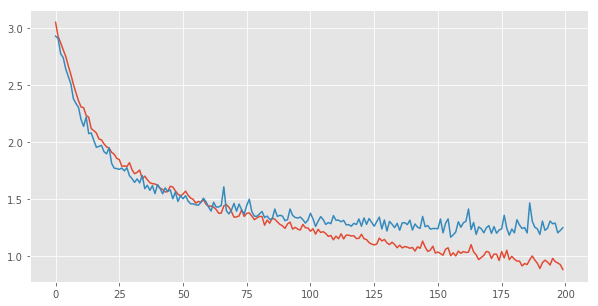

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

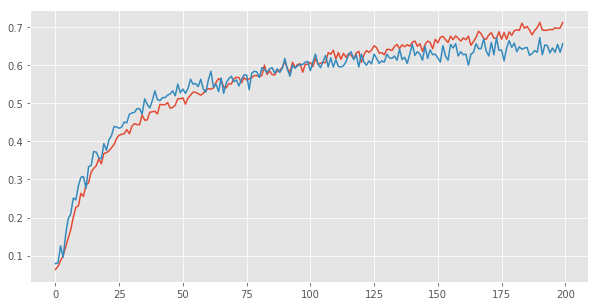

In [28]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.5922705314009662
Confusion matrix, without normalization
[[38  0  0  1  0  2  0  0  2  1  0  0  0  2  0  0  1  6  0]
 [ 3 20  1  2  5  0  3  0  0  2  0  0  1  1  0  0  3  0  1]
 [ 0  0 40  0  1  0  4  3  0  0  0  1  0  0  0  3  1  2  0]
 [ 1  1  2 24  1  2  5  9  4  6  0  0  0  5  0  1  0  2  1]
 [ 1  2  0  0 38  0  2  1  1  0  0  0  0  0  0  2  0  0  1]
 [ 1  0  0  1  0 29  0  2  3  0  0  1  6  2  0  0  0  2  2]
 [ 7  2  5  0  0  1 26  1  0  2  0  1  1  0  1  2  3  1  3]
 [ 0  0  5  0  0  0  1 30  0  2  1  0  0  0  1  0  2  0  6]
 [ 7  2  0  0  0  5  2  5 48  3  0  2  2  0  0  0  0  1  1]
 [ 0  2  1  1  2  0  1  2  4 34  0  8  0  2  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  5  0  1 66  0  0  0  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  1  2  0  1 48  1  1  0  0  1  0  6]
 [ 4  1  6  0  2  7  5  3  0  0  0  3 21  1  1  0  1  3  1]
 [ 1  1  1  0  0  0  1  0  0  1  0  1  1 18  1  1  0  0  2]
 [ 0  0  1  0  7  0  0  0  0  0  0  0  0  0 49  0  1  0  0]
 [ 4  0  1  0  0  1  2  2  2  1  1  1  0 

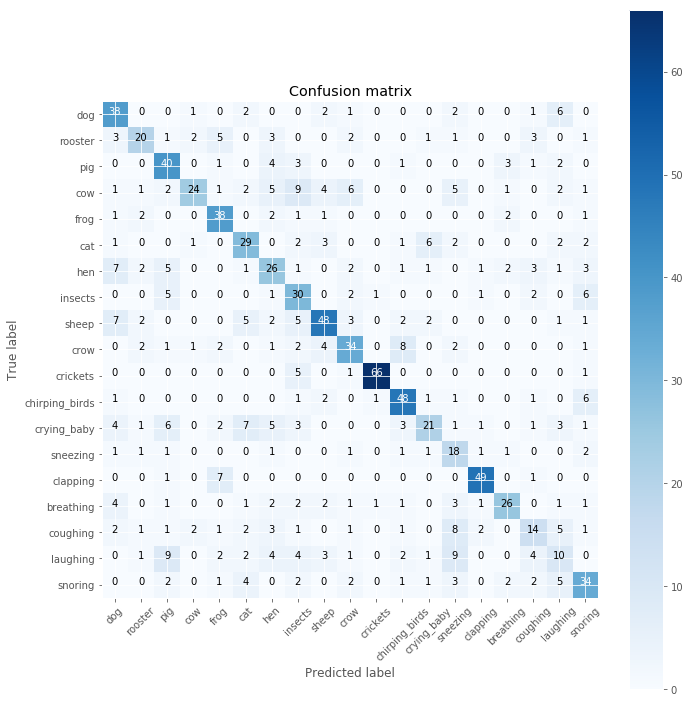

In [29]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [30]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [31]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(16, (3,3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Convolution2D(32, (5,2), name='conv2', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [32]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs * 2, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 16)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 2, 16)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 32)          5152      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

6016/6016 [==============================] - 3s 467us/step - loss: 1.8530 - acc: 0.3921 - mean_absolute_error: 0.0477 - val_loss: 1.7934 - val_acc: 0.4058 - val_mean_absolute_error: 0.0467
Epoch 31/200
6016/6016 [==============================] - 3s 465us/step - loss: 1.8644 - acc: 0.3918 - mean_absolute_error: 0.0479 - val_loss: 1.7935 - val_acc: 0.4350 - val_mean_absolute_error: 0.0466
Epoch 32/200
6016/6016 [==============================] - 3s 505us/step - loss: 1.8619 - acc: 0.3890 - mean_absolute_error: 0.0480 - val_loss: 1.8391 - val_acc: 0.4105 - val_mean_absolute_error: 0.0460
Epoch 33/200
6016/6016 [==============================] - 3s 463us/step - loss: 1.8313 - acc: 0.3994 - mean_absolute_error: 0.0471 - val_loss: 1.7344 - val_acc: 0.4388 - val_mean_absolute_error: 0.0458
Epoch 34/200
6016/6016 [==============================] - 3s 477us/step - loss: 1.8161 - acc: 0.4079 - mean_absolute_error: 0.0469 - val_loss: 1.7653 - val_acc: 0.4463 - val_mean_absolute_error: 0.0460
Epo

Epoch 71/200
6016/6016 [==============================] - 3s 472us/step - loss: 1.5352 - acc: 0.4882 - mean_absolute_error: 0.0416 - val_loss: 1.5393 - val_acc: 0.5028 - val_mean_absolute_error: 0.0404
Epoch 72/200
6016/6016 [==============================] - 3s 488us/step - loss: 1.5729 - acc: 0.4849 - mean_absolute_error: 0.0419 - val_loss: 1.5710 - val_acc: 0.4962 - val_mean_absolute_error: 0.0409
Epoch 73/200
6016/6016 [==============================] - 3s 470us/step - loss: 1.4911 - acc: 0.5138 - mean_absolute_error: 0.0408 - val_loss: 1.4995 - val_acc: 0.5254 - val_mean_absolute_error: 0.0390
Epoch 74/200
6016/6016 [==============================] - 3s 484us/step - loss: 1.5129 - acc: 0.5071 - mean_absolute_error: 0.0408 - val_loss: 1.4864 - val_acc: 0.5160 - val_mean_absolute_error: 0.0400
Epoch 75/200
6016/6016 [==============================] - 3s 478us/step - loss: 1.4871 - acc: 0.5012 - mean_absolute_error: 0.0406 - val_loss: 1.5292 - val_acc: 0.5141 - val_mean_absolute_erro

6016/6016 [==============================] - 3s 473us/step - loss: 1.3232 - acc: 0.5582 - mean_absolute_error: 0.0367 - val_loss: 1.4190 - val_acc: 0.5612 - val_mean_absolute_error: 0.0361
Epoch 112/200
6016/6016 [==============================] - 3s 469us/step - loss: 1.3993 - acc: 0.5384 - mean_absolute_error: 0.0382 - val_loss: 1.3546 - val_acc: 0.5847 - val_mean_absolute_error: 0.0362
Epoch 113/200
6016/6016 [==============================] - 3s 466us/step - loss: 1.3375 - acc: 0.5565 - mean_absolute_error: 0.0370 - val_loss: 1.3762 - val_acc: 0.5687 - val_mean_absolute_error: 0.0361
Epoch 114/200
6016/6016 [==============================] - 3s 471us/step - loss: 1.3345 - acc: 0.5517 - mean_absolute_error: 0.0371 - val_loss: 1.4218 - val_acc: 0.5546 - val_mean_absolute_error: 0.0364
Epoch 115/200
6016/6016 [==============================] - 3s 481us/step - loss: 1.3306 - acc: 0.5597 - mean_absolute_error: 0.0367 - val_loss: 1.4472 - val_acc: 0.5518 - val_mean_absolute_error: 0.0370

6016/6016 [==============================] - 3s 492us/step - loss: 1.2319 - acc: 0.5873 - mean_absolute_error: 0.0346 - val_loss: 1.3281 - val_acc: 0.6073 - val_mean_absolute_error: 0.0340
Epoch 152/200
6016/6016 [==============================] - 3s 524us/step - loss: 1.2031 - acc: 0.5971 - mean_absolute_error: 0.0339 - val_loss: 1.3575 - val_acc: 0.5829 - val_mean_absolute_error: 0.0336
Epoch 153/200
6016/6016 [==============================] - 3s 483us/step - loss: 1.2339 - acc: 0.5928 - mean_absolute_error: 0.0343 - val_loss: 1.3538 - val_acc: 0.5932 - val_mean_absolute_error: 0.0341
Epoch 154/200
6016/6016 [==============================] - 3s 509us/step - loss: 1.2423 - acc: 0.5893 - mean_absolute_error: 0.0345 - val_loss: 1.3794 - val_acc: 0.5744 - val_mean_absolute_error: 0.0350
Epoch 155/200
6016/6016 [==============================] - 3s 495us/step - loss: 1.1969 - acc: 0.6021 - mean_absolute_error: 0.0337 - val_loss: 1.3424 - val_acc: 0.5782 - val_mean_absolute_error: 0.0338

6016/6016 [==============================] - 3s 476us/step - loss: 1.1461 - acc: 0.6185 - mean_absolute_error: 0.0322 - val_loss: 1.2507 - val_acc: 0.6365 - val_mean_absolute_error: 0.0318
Epoch 192/200
6016/6016 [==============================] - 3s 473us/step - loss: 1.0872 - acc: 0.6333 - mean_absolute_error: 0.0311 - val_loss: 1.2533 - val_acc: 0.6337 - val_mean_absolute_error: 0.0311
Epoch 193/200
6016/6016 [==============================] - 3s 578us/step - loss: 1.1840 - acc: 0.6147 - mean_absolute_error: 0.0326 - val_loss: 1.4061 - val_acc: 0.5716 - val_mean_absolute_error: 0.0340
Epoch 194/200
6016/6016 [==============================] - 3s 510us/step - loss: 1.1427 - acc: 0.6154 - mean_absolute_error: 0.0324 - val_loss: 1.3440 - val_acc: 0.5932 - val_mean_absolute_error: 0.0331
Epoch 195/200
6016/6016 [==============================] - 3s 489us/step - loss: 1.1008 - acc: 0.6318 - mean_absolute_error: 0.0316 - val_loss: 1.2269 - val_acc: 0.6347 - val_mean_absolute_error: 0.0308

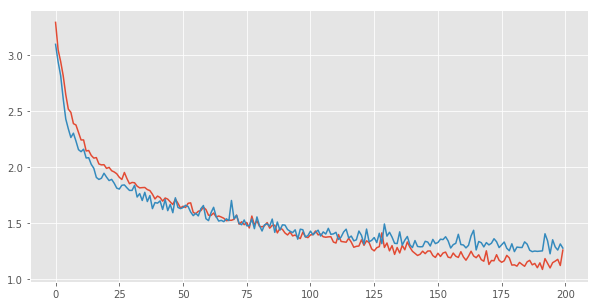

In [33]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

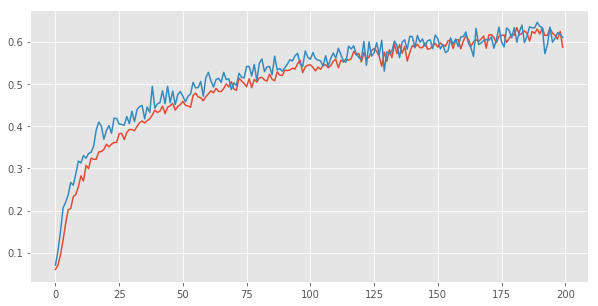

In [34]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.5898305084745763
Confusion matrix, without normalization
[[52  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0
   0  0  0  0  1  0  0]
 [ 0 38  0  0  0  0  7  0  0  0  0  0  0  0  0  0  2  1  0  0  0  2  3  0
   0  7  1  0  0  1  0]
 [ 0  0 46  0  1  0  2  0  3  0  0  0  0  5  0  0  0  0  0  0  1  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  1 22  0  1  0  2  0  0  0  0  2  0  3  2  0  0  5  4  1  0  0  0
   0  0  0  0  0  3  0]
 [ 4 16  0  0 34  0  1  4  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0
   0  2  3  0  0  0  0]
 [ 0  0  4  0  0 18  0  1  1  0  1  0  2 11  0  3  0  0  2  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 3  1  0  1  2  0 34  1  0  0  0  0  0  0  0  0  3  1  1  0  0  0  1  1
   0  2  0  0  1  0  0]
 [ 0  0  0  0  2  0  0 41  0  0  0  0  0  0  0  1  1  0  0  0  0  4  0  0
   0  1  2  0  3  5  1]
 [ 0  0  3  0  0  0  0  0 33  0  1  0  1  6  0  2  0  0  0  1  0  0  0  0
   0  0  0  0  0  4  0]
 [ 0  0  6  0  0  4  9  0  2 31  0  1  0  1  0  0  0  0  1 

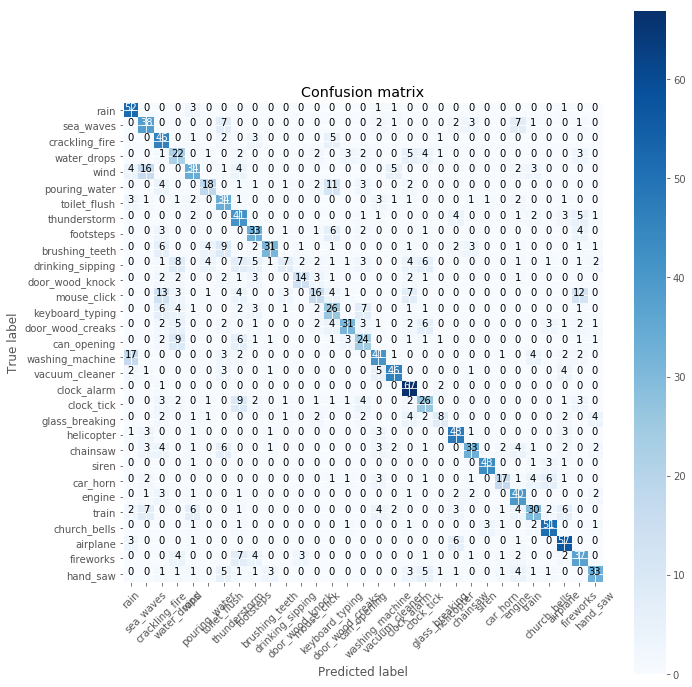

In [35]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [36]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 6.695456504821777
	Processing Time: 6.42946195602417
	Processing Time: 6.802298307418823
	Processing Time: 6.608965873718262


In [37]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [38]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [39]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


0.7078944587311093
Confusion matrix, without normalization
[[11343  9761]
 [ 6823 28847]]


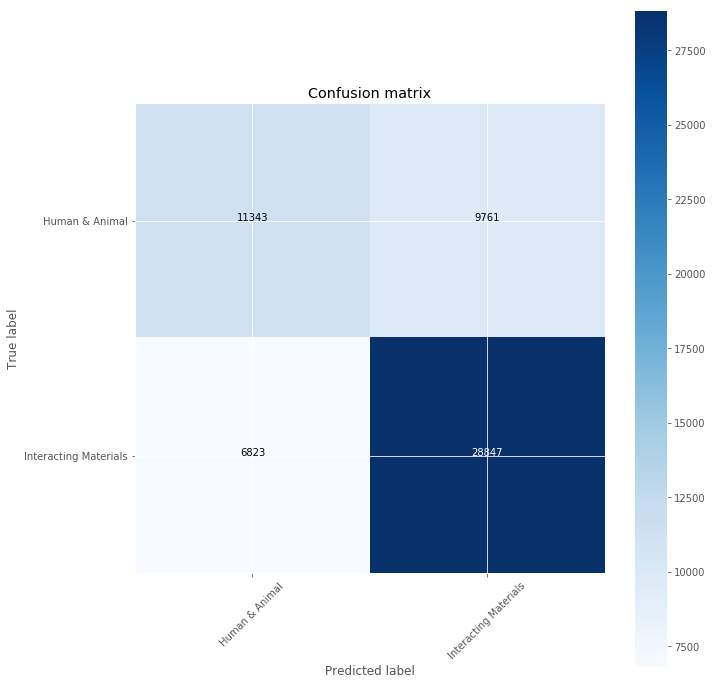

In [40]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [41]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.3121683093252464
Confusion matrix, without normalization
[[502  17  29  43  28  24 114   2  37  22   0   3  34  83  29  25  32  64
   19]
 [ 83 254   7  36  23  68  46   2  30  53   8   6  50 137   3  13  14  34
   18]
 [  7  10 277   9  25   4  80 108  35  41  10  33  32  15 160  27  70  60
   73]
 [ 93  10  31 310  12  37 253  49  75  30   8  11  53  22   4  39  16  29
   31]
 [ 74  44  40  19 574   5   1   1  63  74   4  81  19  24 144  28  16  21
   12]
 [127  98   2  96  21 168  38  40  54  37   6  21  71  54  11   8  23  65
   89]
 [207  20  61  25  18  29 326  65  22  10   9   8 115  21  16  61  38  69
   33]
 [ 52   0 139  76  38  66  46 490  49  25  10  35  25   8  48  15  15   9
   65]
 [ 55  31  46  43 113  33  70 103 471  47   4  55  13  10  27  34  18  22
   39]
 [ 62  14  60  61 195   1  84  77  99 316   8  24   0  11  47  33   8  13
   24]
 [ 35   6  46   0   1  27  11  81   6  94 183 541   1  33   4   7  11   6
  155]
 [ 39   6  78   3  23  11  57  64  48  14  75 636 

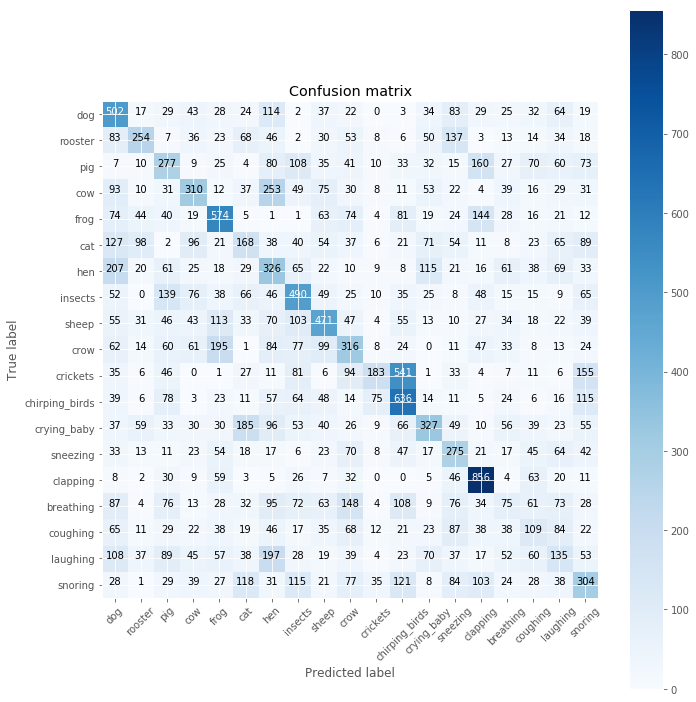

In [42]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.20602747406784414
Confusion matrix, without normalization
[[387  33  15   0  20   0 298  37   0  18   0   1   0   0   6   0  33  11
    0   0  13  19  11   0   0   7   8   0 331   0   0]
 [ 64 204   1   1  15   0 523   3   2   2   0   0   0   0   1   0  10  22
    6   1   0   9 147   3   0  95  25  17  90   1   0]
 [ 10  23 363   2  37 105 177   6  30  77   5   3  31  67  46  17   6  25
    3  10   9   5  80   0   2  50   6   0   8   4   7]
 [  0   1  98 105   4  96  17  99  39  27  15  36  39  53  27  80   0   1
   42  66  12   2   2   2   0  15   3  19  11  75  46]
 [  1 191   0   0  95   0  20  44   1   3   0  10   0   1   0   0  49  12
    0   0   0  36  32 127   2 117 338  62  62   0  45]
 [  5   1 153  19   1 452 129   3  22  20  29  18   4 121  25  21   0   0
   67   9  22   1  11  16   5   4   3   2   2   5  11]
 [225  37  12   3  29   3 519  20  11  47   5   8  17   5   2   0  30   7
    3  12  15   5  32   4   1  27  26   2  77   7  47]
 [ 24  22   2   5  79  24  28 213  10

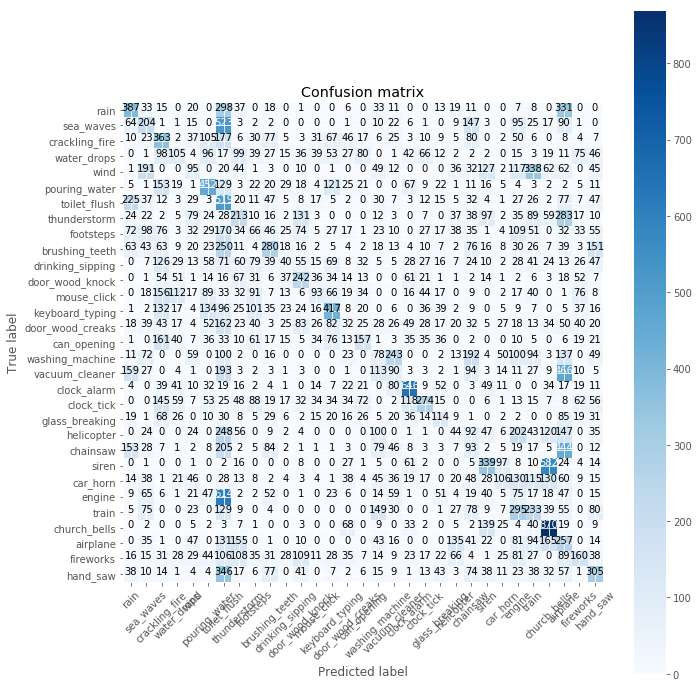

In [43]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

In [44]:
clas.predict_proba(X)

array([[2.3961067e-05, 9.9997604e-01],
       [0.0000000e+00, 1.0000000e+00],
       [2.8269863e-01, 7.1730137e-01],
       ...,
       [3.3948171e-01, 6.6051829e-01],
       [3.5475385e-01, 6.4524615e-01],
       [3.5452652e-01, 6.4547348e-01]], dtype=float32)

# Testing Accuracy of Single File

In [45]:
data_iloc = 1

In [46]:
def load_file_audio_blockwise(file, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    h_cat = []
    cat = []

    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + file['filename'], 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True, 
                         fill_value=0.0)
    SR = sf.info(audio_dir + file['filename']).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        h_cat.append(file.h_category)
        cat.append(file.target)
    if debug:
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

In [47]:
x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)

	Processing Time: 0.01479792594909668


In [48]:
pred_prob = clas.predict_proba(x_file, verbose=1)
pred = clas.predict(x_file, verbose=1)

39/39 [==============================] - 0s 230us/step


In [49]:
np.average(pred_prob, axis=0)

array([0.77636325, 0.22363675], dtype=float32)

In [50]:
pred_prob = anim.predict_proba(x_file, verbose=1)
pred = anim.predict(x_file, verbose=1)

39/39 [==============================] - 0s 228us/step


In [51]:
np.average(pred_prob, axis=0)

array([8.4242174e-06, 1.4592736e-03, 4.4173300e-02, 9.2696014e-04,
       1.8985218e-03, 3.3853382e-03, 6.8637873e-03, 6.5799044e-03,
       1.9054657e-03, 1.1375973e-02, 4.7966843e-03, 7.7630639e-01,
       4.6182010e-02, 1.5191226e-02, 2.7717702e-05, 1.4648337e-02,
       6.6242479e-03, 2.0586515e-02, 3.7059914e-02], dtype=float32)

In [52]:
from collections import Counter
b = Counter(pred)
print(b.most_common(1)[0][0])

14


In [53]:
print(dataset.iloc[data_iloc])

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


In [94]:
predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)
    pred = clas.predict(x_file, verbose=0)[:,0]
    top_pred_probs.append(clas.predict_proba(x_file))
    prob = np.average(top_pred_probs[-1], axis=0)
    if prob[0] > 0.5:
        pred = anim.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(anim.predict_proba(x_file))
    else:
        pred = inter.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(inter.predict_proba(x_file))
    
    full_targets.append(yy_file[0])

print("\tProcessing Time: " + str(time.time() - start_time))

	Processing Time: 0.010910511016845703
	Processing Time: 0.013291120529174805
	Processing Time: 0.012432098388671875
	Processing Time: 0.011313676834106445
	Processing Time: 0.011301279067993164
	Processing Time: 0.011318206787109375
	Processing Time: 0.009670019149780273
	Processing Time: 0.011330366134643555
	Processing Time: 0.01129150390625
	Processing Time: 0.00818777084350586
	Processing Time: 0.009381532669067383
	Processing Time: 0.011310815811157227
	Processing Time: 0.01126551628112793
	Processing Time: 0.011330366134643555
	Processing Time: 0.007528066635131836
	Processing Time: 0.011236429214477539
	Processing Time: 0.011147022247314453
	Processing Time: 0.011393308639526367
	Processing Time: 0.011294364929199219
	Processing Time: 0.011356353759765625
	Processing Time: 0.011594295501708984
	Processing Time: 0.011373281478881836
	Processing Time: 0.011382818222045898
	Processing Time: 0.011337041854858398
	Processing Time: 0.012565851211547852
	Processing Time: 0.01261377334

	Processing Time: 0.011229515075683594
	Processing Time: 0.009384632110595703
	Processing Time: 0.011647939682006836
	Processing Time: 0.011220693588256836
	Processing Time: 0.01118326187133789
	Processing Time: 0.011227846145629883
	Processing Time: 0.011192798614501953
	Processing Time: 0.011229276657104492
	Processing Time: 0.011235237121582031
	Processing Time: 0.012262582778930664
	Processing Time: 0.012280941009521484
	Processing Time: 0.012294292449951172
	Processing Time: 0.012238264083862305
	Processing Time: 0.009428024291992188
	Processing Time: 0.00916147232055664
	Processing Time: 0.011289358139038086
	Processing Time: 0.07418632507324219
	Processing Time: 0.011438846588134766
	Processing Time: 0.011310338973999023
	Processing Time: 0.011275529861450195
	Processing Time: 0.011334419250488281
	Processing Time: 0.011244058609008789
	Processing Time: 0.017841339111328125
	Processing Time: 0.01136016845703125
	Processing Time: 0.01240849494934082
	Processing Time: 0.0123007297

	Processing Time: 0.012458086013793945
	Processing Time: 0.0114288330078125
	Processing Time: 0.011554718017578125
	Processing Time: 0.011240720748901367
	Processing Time: 0.051886558532714844
	Processing Time: 0.011359214782714844
	Processing Time: 0.01123189926147461
	Processing Time: 0.011198759078979492
	Processing Time: 0.011159896850585938
	Processing Time: 0.011273860931396484
	Processing Time: 0.011165380477905273
	Processing Time: 0.011228322982788086
	Processing Time: 0.011211633682250977
	Processing Time: 0.011201143264770508
	Processing Time: 0.011623620986938477
	Processing Time: 0.013322114944458008
	Processing Time: 0.011255741119384766
	Processing Time: 0.011111974716186523
	Processing Time: 0.010375738143920898
	Processing Time: 0.01114964485168457
	Processing Time: 0.011197090148925781
	Processing Time: 0.011104345321655273
	Processing Time: 0.011029481887817383
	Processing Time: 0.010706901550292969
	Processing Time: 0.011183738708496094
	Processing Time: 0.011071205

	Processing Time: 0.01123046875
	Processing Time: 0.011086702346801758
	Processing Time: 0.011212348937988281
	Processing Time: 0.011059284210205078
	Processing Time: 0.010312557220458984
	Processing Time: 0.011342048645019531
	Processing Time: 0.011299371719360352
	Processing Time: 0.011431694030761719
	Processing Time: 0.011296987533569336
	Processing Time: 0.011404991149902344
	Processing Time: 0.008789300918579102
	Processing Time: 0.011336565017700195
	Processing Time: 0.011287212371826172
	Processing Time: 0.011466741561889648
	Processing Time: 0.011298656463623047
	Processing Time: 0.011237382888793945
	Processing Time: 0.011186599731445312
	Processing Time: 0.011048316955566406
	Processing Time: 0.011033058166503906
	Processing Time: 0.009246110916137695
	Processing Time: 0.010118246078491211
	Processing Time: 0.009476423263549805
	Processing Time: 0.011157989501953125
	Processing Time: 0.011209964752197266
	Processing Time: 0.010141372680664062
	Processing Time: 0.011337041854

	Processing Time: 0.011246919631958008
	Processing Time: 0.011140108108520508
	Processing Time: 0.012408733367919922
	Processing Time: 0.010913848876953125
	Processing Time: 0.011104106903076172
	Processing Time: 0.011078834533691406
	Processing Time: 0.010969161987304688
	Processing Time: 0.012428998947143555
	Processing Time: 0.011062860488891602
	Processing Time: 0.011196136474609375
	Processing Time: 0.011368036270141602
	Processing Time: 0.011165857315063477
	Processing Time: 0.01224970817565918
	Processing Time: 0.01235342025756836
	Processing Time: 0.012365579605102539
	Processing Time: 0.012314319610595703
	Processing Time: 0.011076211929321289
	Processing Time: 0.012403249740600586
	Processing Time: 0.011106729507446289
	Processing Time: 0.012232780456542969
	Processing Time: 0.011124134063720703
	Processing Time: 0.010888099670410156
	Processing Time: 0.011035919189453125
	Processing Time: 0.008495330810546875
	Processing Time: 0.011145830154418945
	Processing Time: 0.0110514

	Processing Time: 0.011182308197021484
	Processing Time: 0.011238813400268555
	Processing Time: 0.011155128479003906
	Processing Time: 0.009387969970703125
	Processing Time: 0.00861048698425293
	Processing Time: 0.014237642288208008
	Processing Time: 0.011259317398071289
	Processing Time: 0.010988950729370117
	Processing Time: 0.011017560958862305
	Processing Time: 0.012401819229125977
	Processing Time: 0.01222848892211914
	Processing Time: 0.011172771453857422
	Processing Time: 0.008862733840942383
	Processing Time: 0.009145259857177734
	Processing Time: 0.00872659683227539
	Processing Time: 0.008318424224853516
	Processing Time: 0.011162281036376953
	Processing Time: 0.010978937149047852
	Processing Time: 0.012203693389892578
	Processing Time: 0.012148618698120117
	Processing Time: 0.012188911437988281
	Processing Time: 0.012222051620483398
	Processing Time: 0.012216329574584961
	Processing Time: 0.012274026870727539
	Processing Time: 0.012192726135253906
	Processing Time: 0.01104450

	Processing Time: 0.01122593879699707
	Processing Time: 0.011198759078979492
	Processing Time: 0.008420228958129883
	Processing Time: 0.011347532272338867
	Processing Time: 0.011221647262573242
	Processing Time: 0.01127934455871582
	Processing Time: 0.01122426986694336
	Processing Time: 0.011231422424316406
	Processing Time: 0.011162281036376953
	Processing Time: 0.011200666427612305
	Processing Time: 0.009106636047363281
	Processing Time: 0.011177778244018555
	Processing Time: 0.01121973991394043
	Processing Time: 0.011125802993774414
	Processing Time: 0.011240482330322266
	Processing Time: 0.011165380477905273
	Processing Time: 0.011199474334716797
	Processing Time: 0.011223316192626953
	Processing Time: 0.01117253303527832
	Processing Time: 0.011196613311767578
	Processing Time: 0.011211395263671875
	Processing Time: 0.011108160018920898
	Processing Time: 0.01113128662109375
	Processing Time: 0.011258840560913086
	Processing Time: 0.008192300796508789
	Processing Time: 0.01230525970

	Processing Time: 0.011284828186035156
	Processing Time: 0.011235713958740234
	Processing Time: 0.011246204376220703
	Processing Time: 0.011249065399169922
	Processing Time: 0.011207342147827148
	Processing Time: 0.011232137680053711
	Processing Time: 0.011213302612304688
	Processing Time: 0.01115107536315918
	Processing Time: 0.011251688003540039
	Processing Time: 0.011226892471313477
	Processing Time: 0.01114344596862793
	Processing Time: 0.008944034576416016
	Processing Time: 0.011141300201416016
	Processing Time: 0.01110529899597168
	Processing Time: 0.012204647064208984
	Processing Time: 0.011115789413452148
	Processing Time: 0.011091470718383789
	Processing Time: 0.012188196182250977
	Processing Time: 0.011208534240722656
	Processing Time: 0.011817455291748047
	Processing Time: 0.012267112731933594
	Processing Time: 0.011522769927978516
	Processing Time: 0.011098861694335938
	Processing Time: 0.008304595947265625
	Processing Time: 0.011380434036254883
	Processing Time: 0.01101970

	Processing Time: 0.011001348495483398
	Processing Time: 0.011090993881225586
	Processing Time: 0.010816812515258789
	Processing Time: 0.010965824127197266
	Processing Time: 0.011043310165405273
	Processing Time: 0.011201143264770508
	Processing Time: 0.011391639709472656
	Processing Time: 0.011227130889892578
	Processing Time: 0.011228561401367188
	Processing Time: 0.011251449584960938
	Processing Time: 0.01124715805053711
	Processing Time: 0.011283636093139648
	Processing Time: 0.01122736930847168
	Processing Time: 0.011157751083374023
	Processing Time: 0.011272430419921875
	Processing Time: 0.0112457275390625
	Processing Time: 0.011222124099731445
	Processing Time: 0.011241674423217773
	Processing Time: 0.011260032653808594
	Processing Time: 0.011239767074584961
	Processing Time: 0.011291265487670898
	Processing Time: 0.011150121688842773
	Processing Time: 0.011191606521606445
	Processing Time: 0.011247873306274414
	Processing Time: 0.011245965957641602
	Processing Time: 0.012302160

	Processing Time: 0.011252403259277344
	Processing Time: 0.01121973991394043
	Processing Time: 0.011226654052734375
	Processing Time: 0.009195327758789062
	Processing Time: 0.011215686798095703
	Processing Time: 0.011144876480102539
	Processing Time: 0.011154651641845703
	Processing Time: 0.012221813201904297
	Processing Time: 0.012494087219238281
	Processing Time: 0.011180877685546875
	Processing Time: 0.01111745834350586
	Processing Time: 0.011143684387207031
	Processing Time: 0.011179685592651367
	Processing Time: 0.011204242706298828
	Processing Time: 0.011123418807983398
	Processing Time: 0.011133670806884766
	Processing Time: 0.011148214340209961
	Processing Time: 0.011127710342407227
	Processing Time: 0.011148452758789062
	Processing Time: 0.011125326156616211
	Processing Time: 0.011162996292114258
	Processing Time: 0.011191606521606445
	Processing Time: 0.011132478713989258
	Processing Time: 0.011166572570800781
	Processing Time: 0.011212825775146484
	Processing Time: 0.0111200

In [95]:
targs = np.vstack(full_targets)

0.267
Confusion matrix, without normalization
[[29  0  1 ...  0  0  0]
 [ 3 23  0 ...  0  0  0]
 [ 0  1 15 ...  4  0  2]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  0  0 ...  5  5  0]
 [ 0  0  4 ...  1  0  8]]


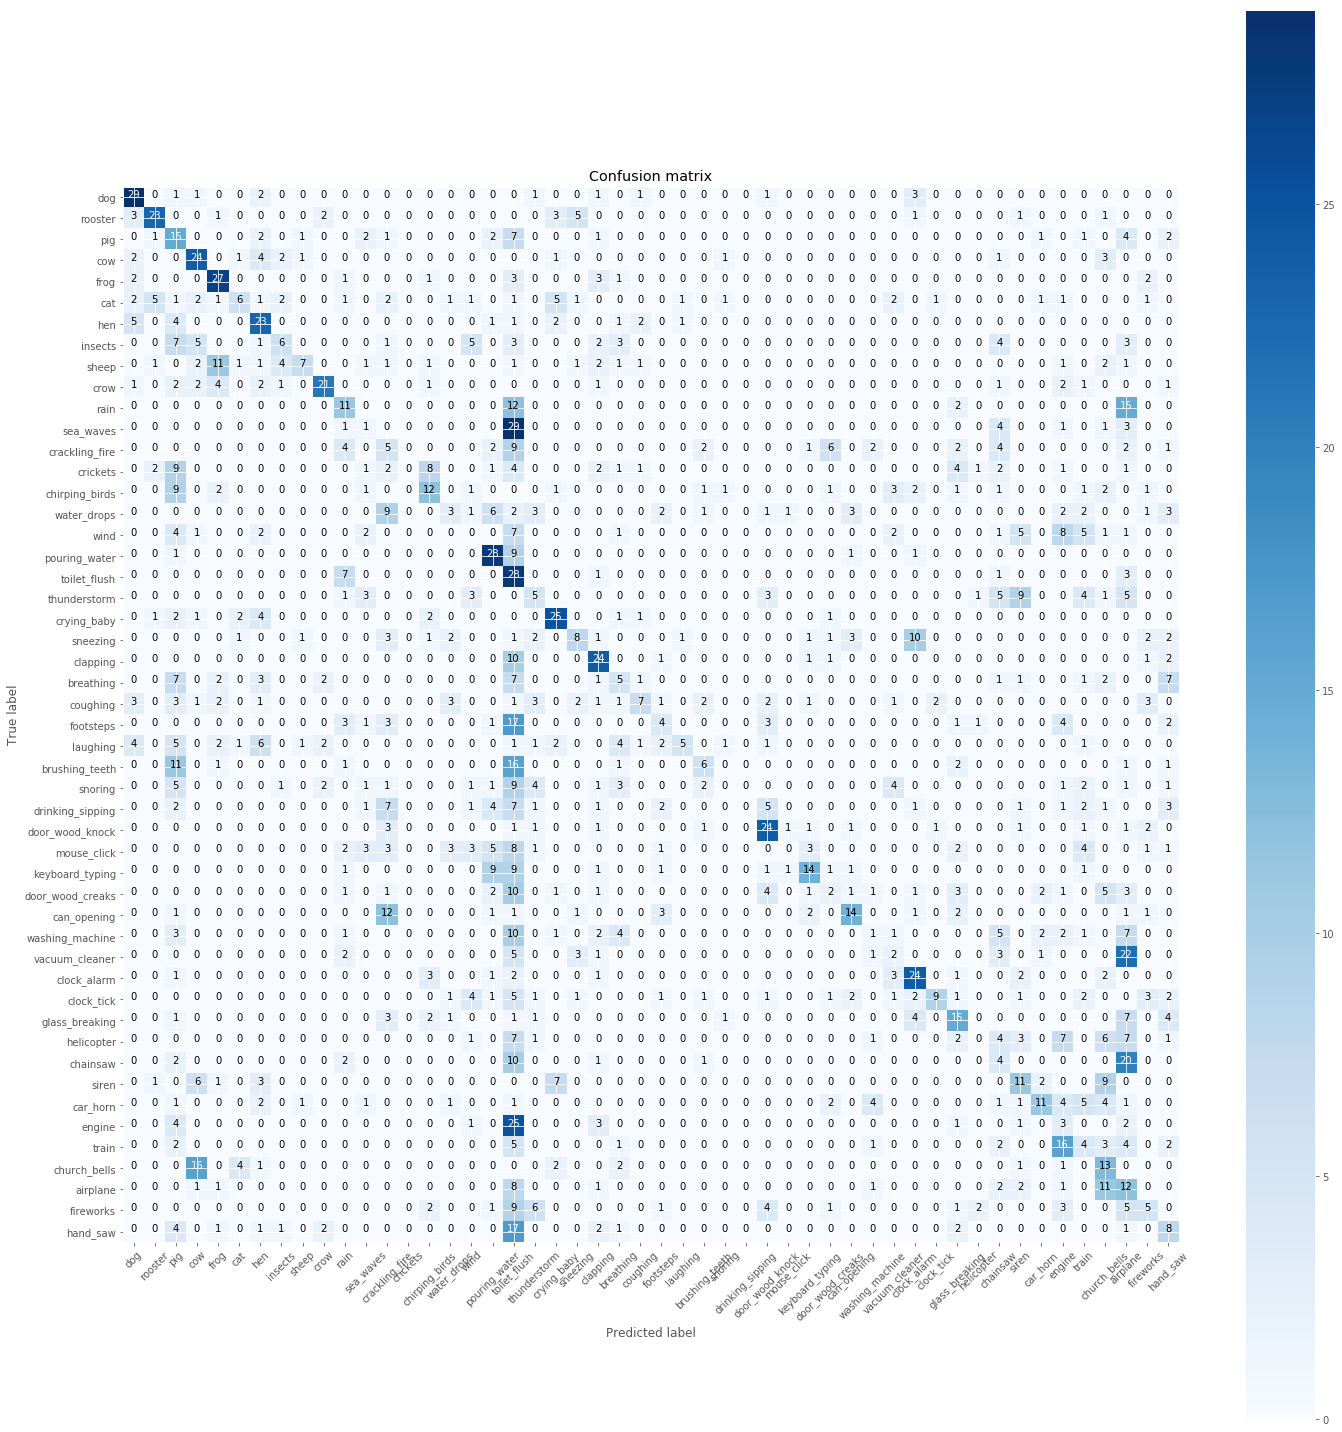

In [96]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

filename      1-100032-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                100032
take                         A
h_category                   0
Name: 0, dtype: object


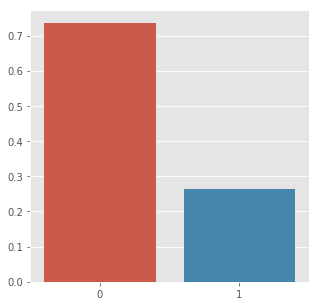

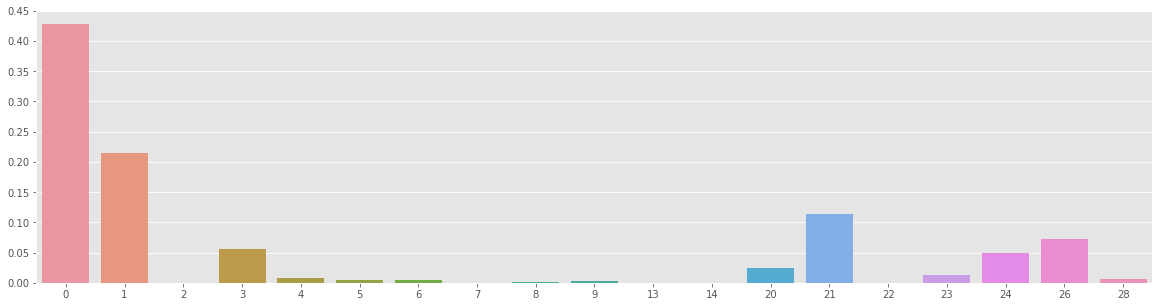

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


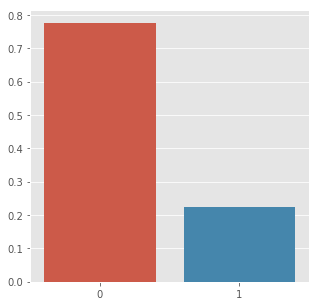

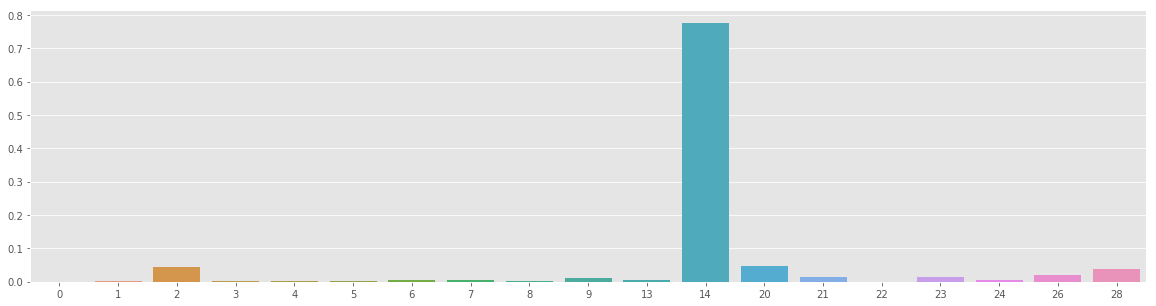

filename      1-100210-A-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          A
h_category                    1
Name: 2, dtype: object


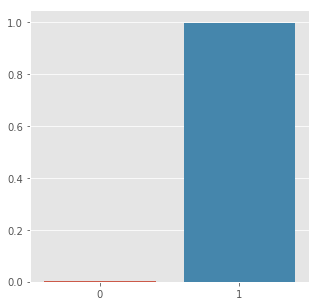

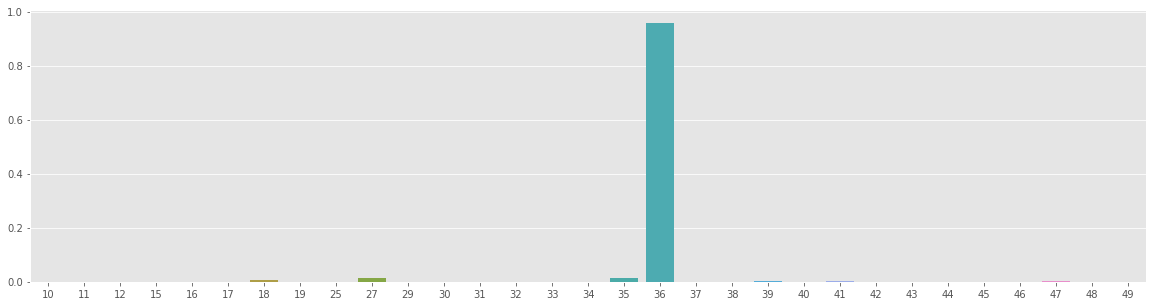

filename      1-100210-B-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          B
h_category                    1
Name: 3, dtype: object


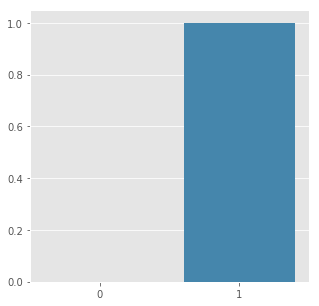

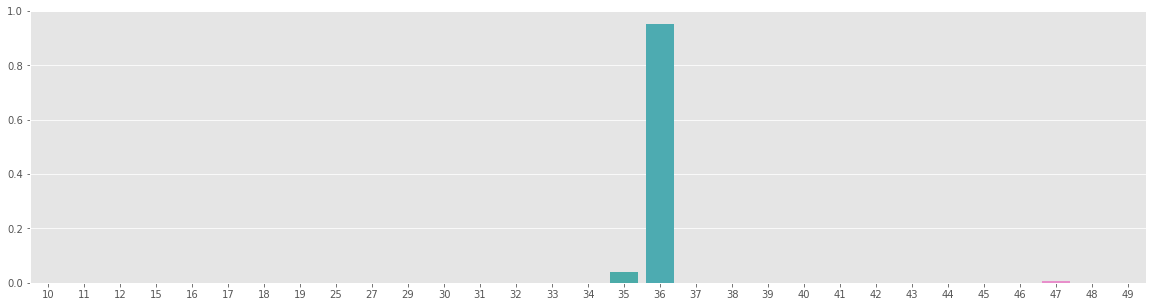

filename      1-101296-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          A
h_category                    1
Name: 4, dtype: object


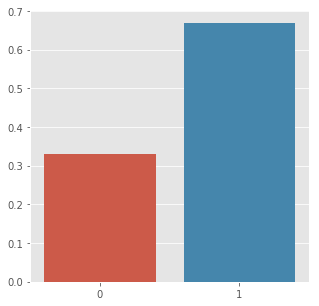

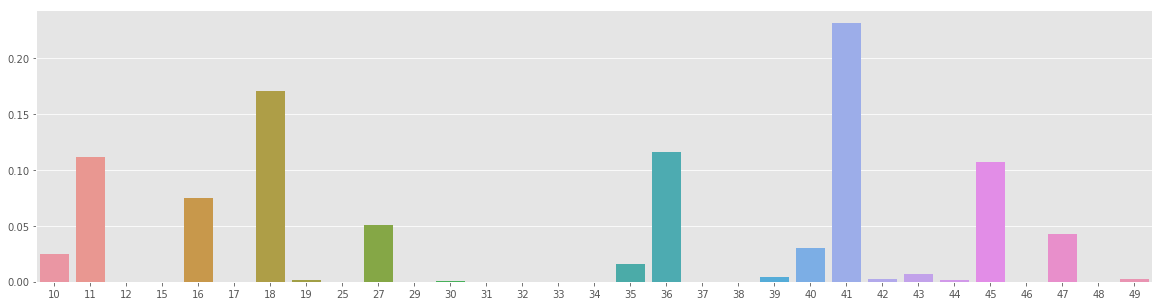

filename      1-101296-B-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          B
h_category                    1
Name: 5, dtype: object


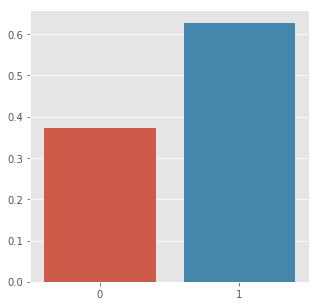

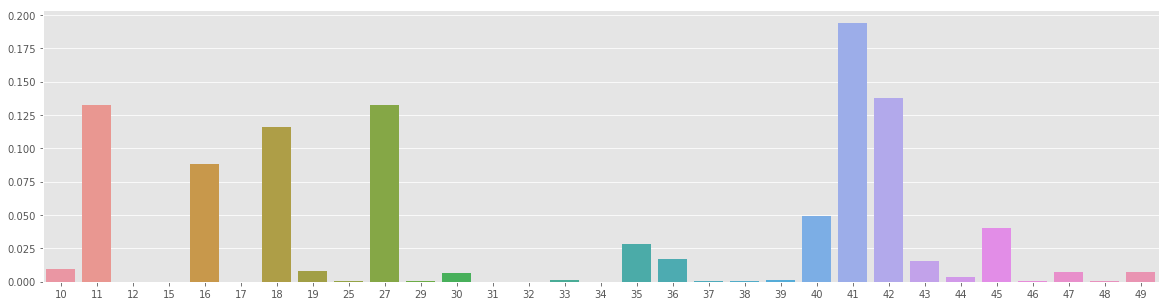

filename      1-101336-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 101336
take                          A
h_category                    1
Name: 6, dtype: object


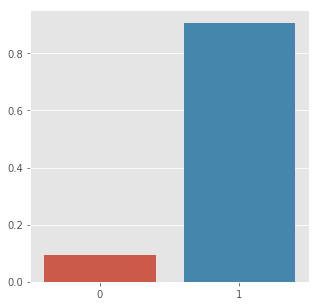

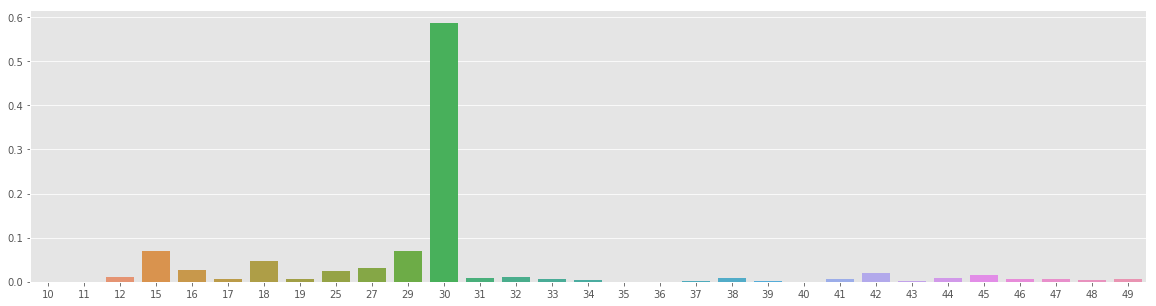

filename      1-101404-A-34.wav
fold                          1
target                       34
category            can_opening
esc10                     False
src_file                 101404
take                          A
h_category                    1
Name: 7, dtype: object


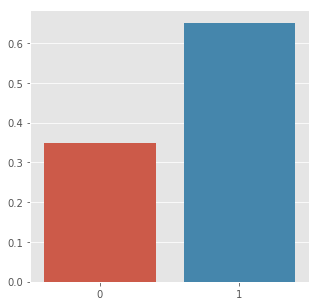

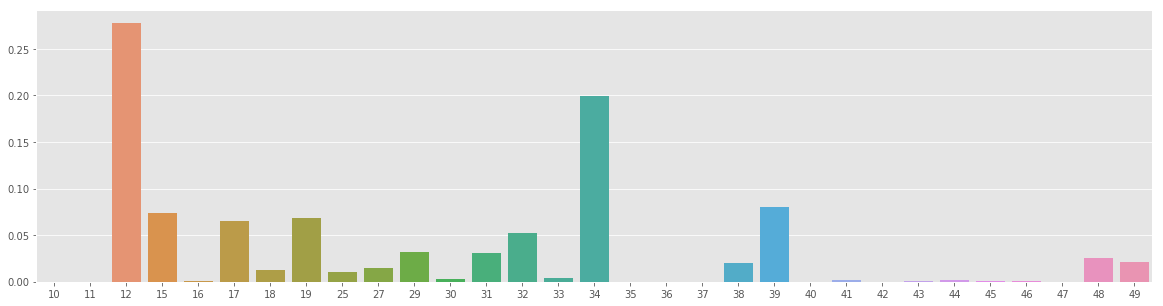

filename      1-103298-A-9.wav
fold                         1
target                       9
category                  crow
esc10                    False
src_file                103298
take                         A
h_category                   0
Name: 8, dtype: object


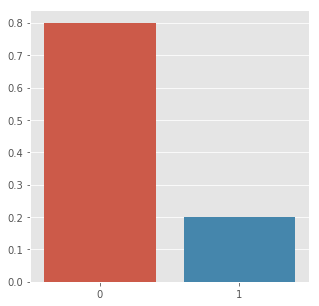

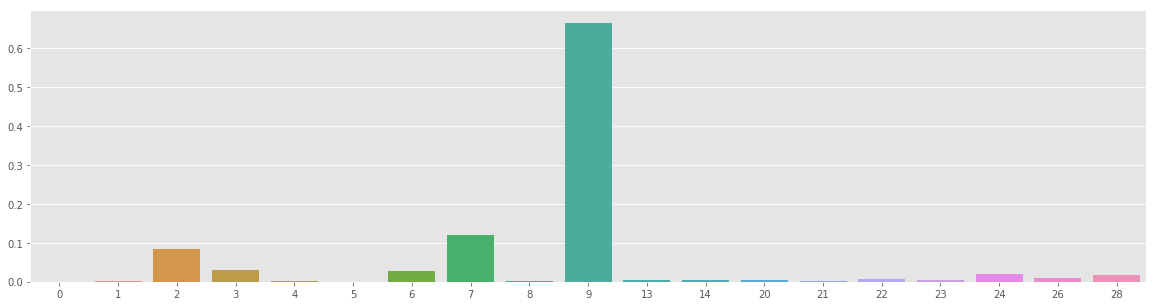

filename      1-103995-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103995
take                          A
h_category                    1
Name: 9, dtype: object


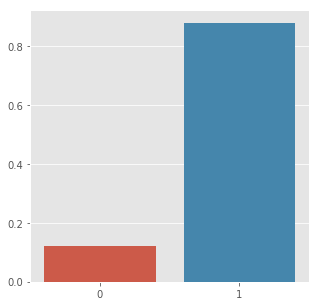

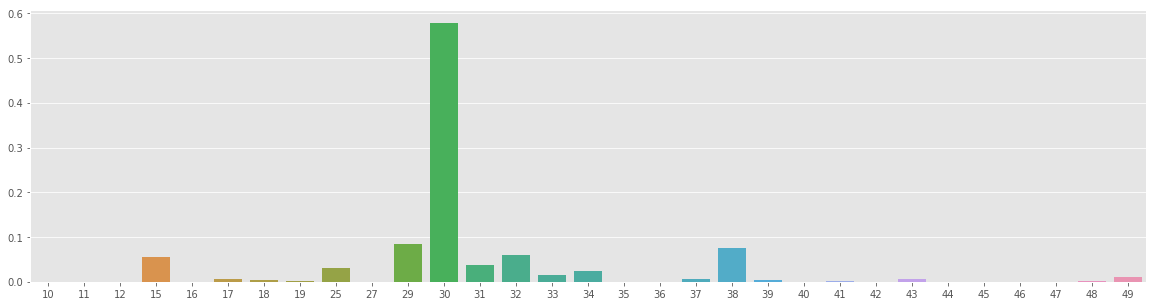

filename      1-103999-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103999
take                          A
h_category                    1
Name: 10, dtype: object


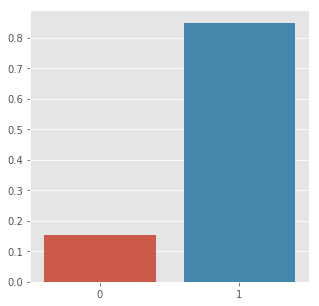

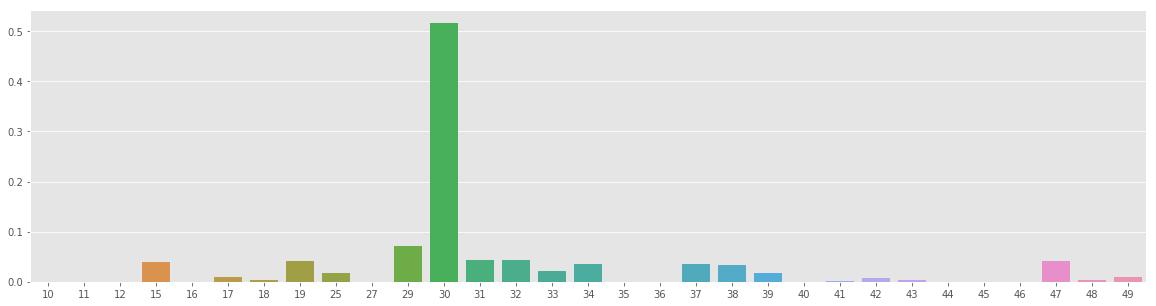

filename      1-104089-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          A
h_category                    0
Name: 11, dtype: object


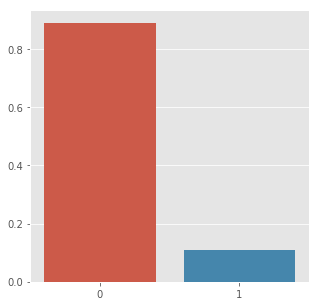

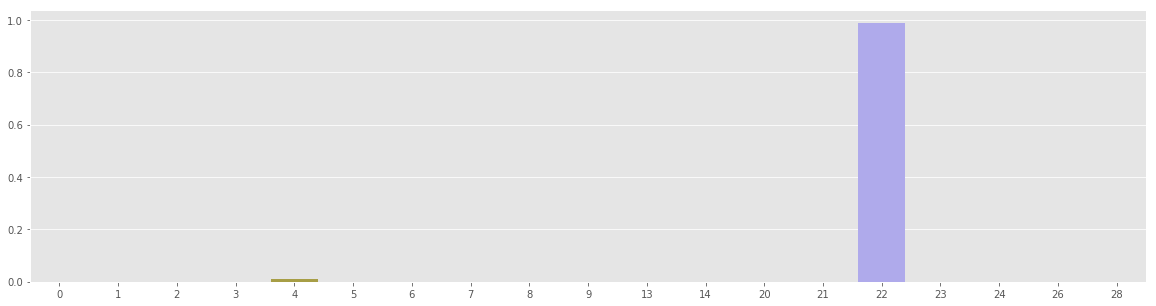

filename      1-104089-B-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          B
h_category                    0
Name: 12, dtype: object


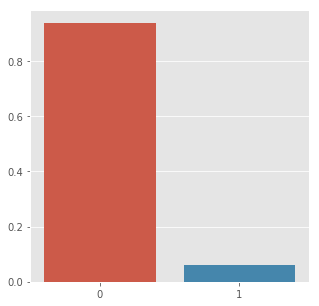

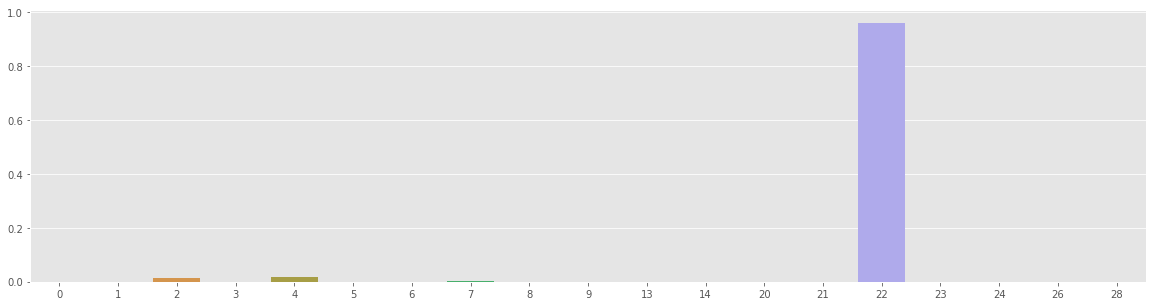

filename      1-105224-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 105224
take                          A
h_category                    0
Name: 13, dtype: object


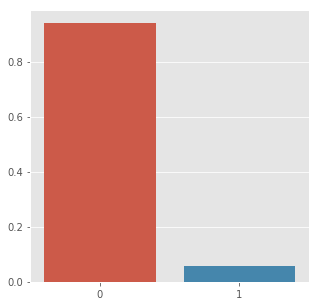

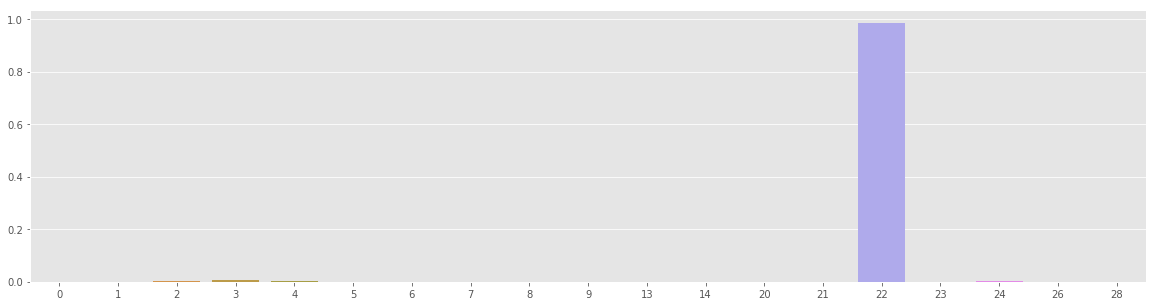

filename      1-110389-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                110389
take                         A
h_category                   0
Name: 14, dtype: object


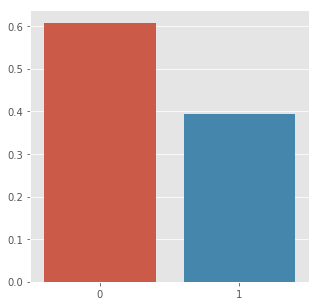

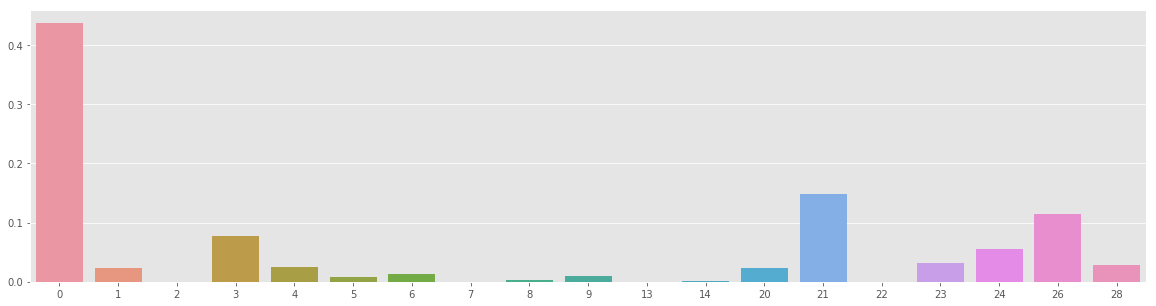

filename      1-110537-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 110537
take                          A
h_category                    0
Name: 15, dtype: object


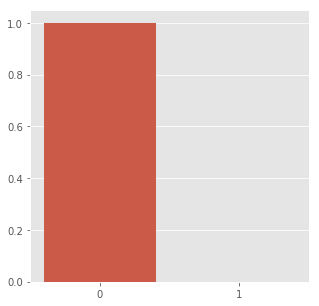

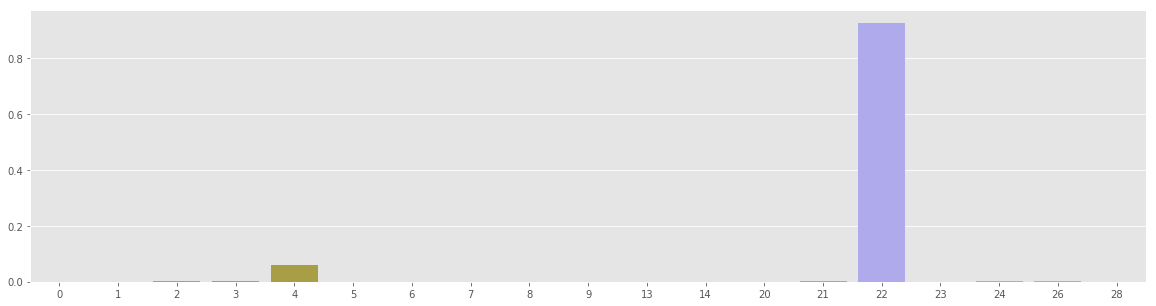

filename      1-115521-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 115521
take                          A
h_category                    1
Name: 16, dtype: object


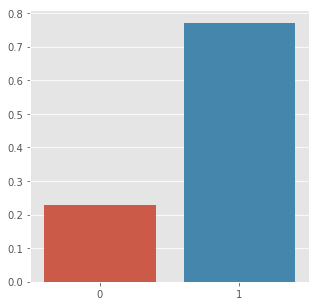

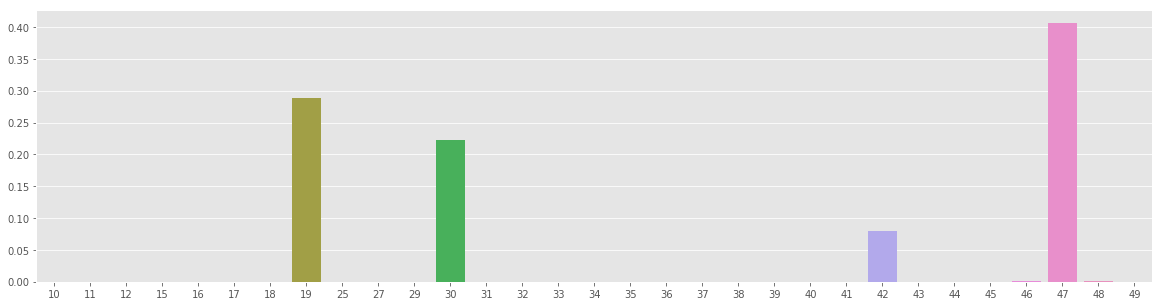

filename      1-115545-A-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          A
h_category                    1
Name: 17, dtype: object


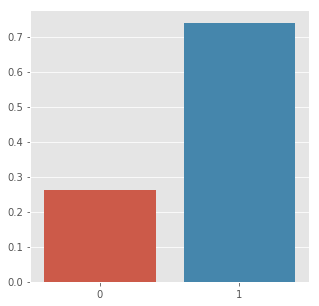

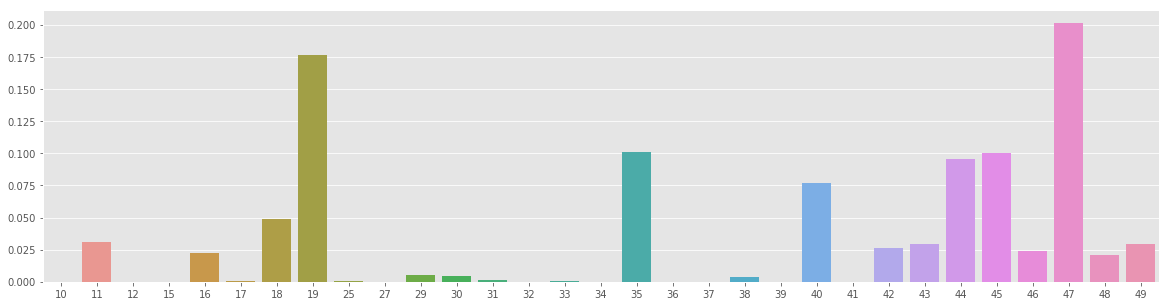

filename      1-115545-B-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          B
h_category                    1
Name: 18, dtype: object


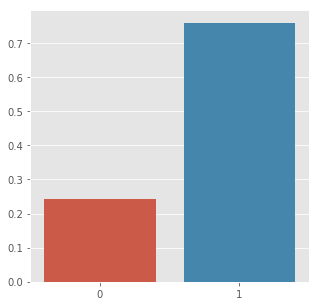

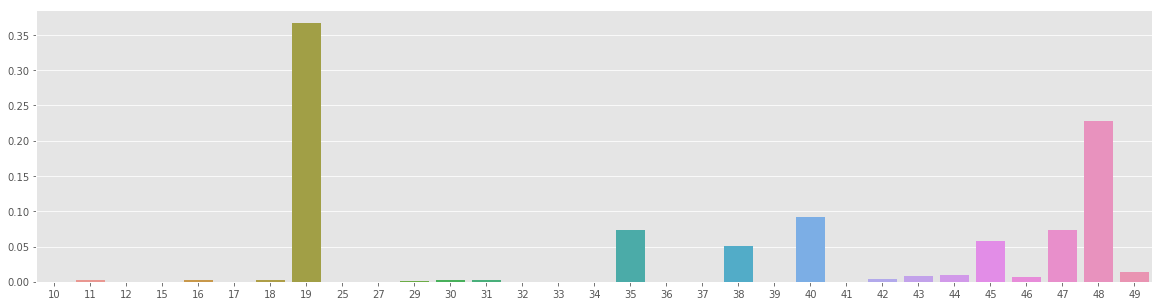

filename      1-115545-C-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          C
h_category                    1
Name: 19, dtype: object


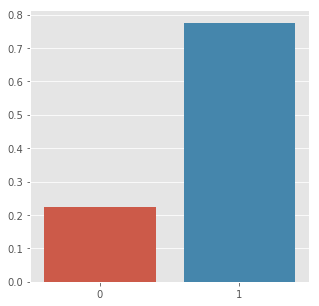

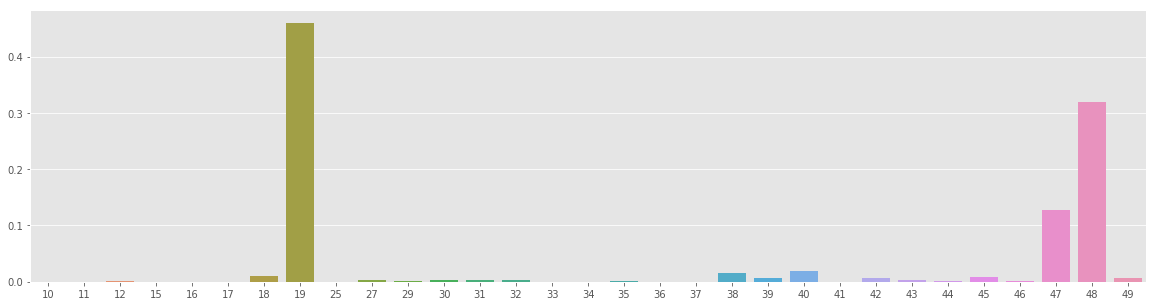

In [97]:
import seaborn as sns

for i in range(0,20):
    prob = pred_probs[i]
    print(dataset.iloc[i])

    xs = np.unique(targets)
    ys = np.average(top_pred_probs[i], axis=0)

    plt.figure(figsize=(5,5))
    sns.barplot(xs, ys)
    
    xs = np.unique(a_targ)
    ys = np.average(prob, axis=0)
    if(len(ys)!=len(xs)):
        xs = np.unique(i_targ)

    plt.figure(figsize=(20,5))
    sns.barplot(xs, ys)
    plt.show()